# Simulation using Concord

In [80]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import Concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [82]:
proj_name = "simulation_trajectory_singlebatch"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/{proj_name}/"
data_dir = Path(data_dir)
data_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix

cpu


'Jan23-1634'

In [83]:
state_key = 'time'
batch_key = 'batch'
state_type = 'trajectory'
batch_type = 'batch_specific_features'
distribution = 'normal'
leiden_key = 'leiden_no_noise'

In [111]:
from Concord.utils.simulation import Simulation

# Create an instance of the Simulation class

sim = Simulation(n_cells=4000, n_genes=500, n_batches=1, n_states=3, 
                 state_type=state_type, 
                 state_distribution = distribution, 
                 state_level=10, 
                 state_min_level=0,
                 state_dispersion=2.0, 
                 program_structure='linear_bidirectional',
                 program_on_time_fraction=0.95,
                 trajectory_program_num=2,
                 trajectory_cell_block_size_ratio=0.99,
                 trajectory_loop_to=None,
                 batch_distribution = distribution,
                 batch_type=batch_type, 
                 batch_level=[10,10], 
                 batch_dispersion=[2.0, 2.0], 
                 non_neg=True, to_int=True,
                 seed=42)

adata_state =  sim.simulate_state()
# Generate the simulated data
#adata, adata_state = sim.simulate_data()

In [112]:
adata_state.shape

(4000, 500)

In [113]:
# Convert middle gene block to a on and off block
gene_indices = np.arange(adata_state.n_vars//2 - 5, adata_state.n_vars//2 + 5)
# Set corresponding gene expression to 0
adata_state.layers['no_noise'][:, gene_indices] = 0
cell_indices = np.arange(adata_state.n_obs//2 - 100, adata_state.n_obs//2 + 100)
adata_state.layers['no_noise'] = sim.simulate_expression_block(
    adata_state.layers['no_noise'], 'linear_bidirectional', gene_indices, cell_indices, mean_expression=10, min_expression=0, on_time_fraction=0.01
)
adata_state.layers['wt_noise'] = Simulation.simulate_distribution(distribution, adata_state.layers['no_noise'], dispersion=2.0)
adata_state.X = adata_state.layers['wt_noise'].copy()
adata = adata_state.copy()

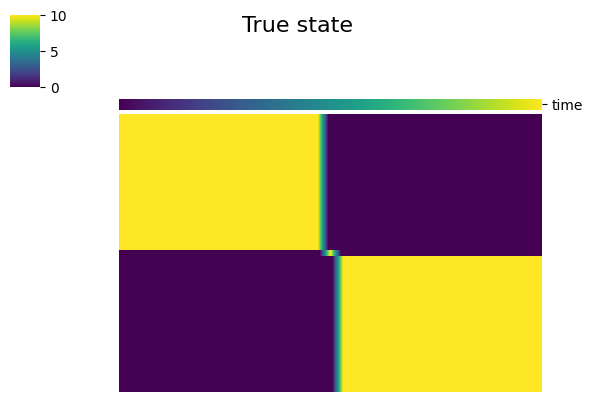

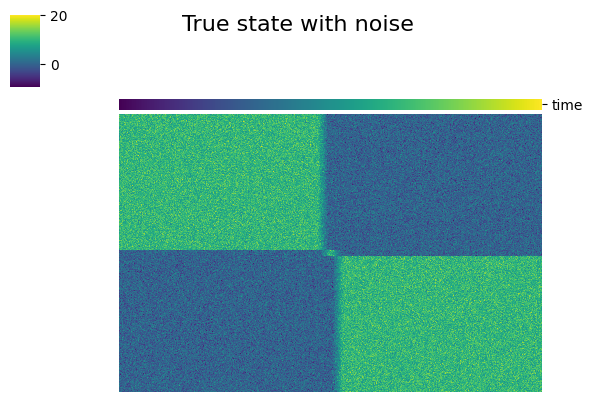

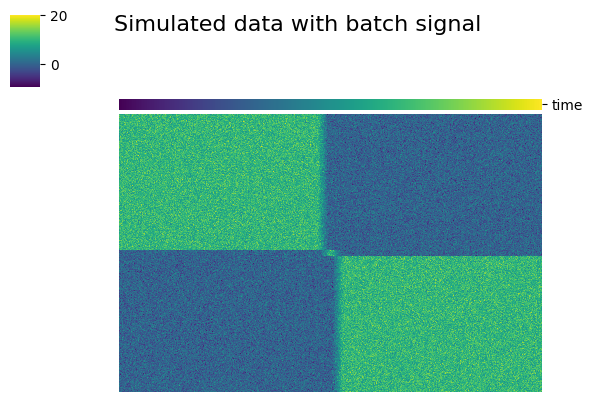

In [114]:
ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state', save_path=save_dir/f'true_state_heatmap_{file_suffix}.svg', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata, val='wt_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state with noise', save_path=save_dir/f'true_state_with_noise_heatmap_{file_suffix}.svg', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Simulated data with batch signal', save_path=save_dir/f'simulated_data_heatmap_{file_suffix}.svg', figsize=(6, 4), dpi=300)

In [115]:
adata.shape

(4000, 500)

### No batch effect, no noise

In [116]:
n_components = 15
ccd.ul.run_pca(adata, source_key='no_noise', result_key='PCA_no_noise', n_pc=n_components, random_state=seed)
ccd.ul.run_umap(adata, source_key='no_noise', result_key='UMAP_no_noise', random_state=seed)
sc.pp.neighbors(adata, use_rep='PCA_no_noise', n_neighbors=30, random_state=seed)
sc.tl.leiden(adata, resolution=1.0, key_added=leiden_key, random_state=seed)
#adata.obs[leiden_key] = adata_state.obs[leiden_key]

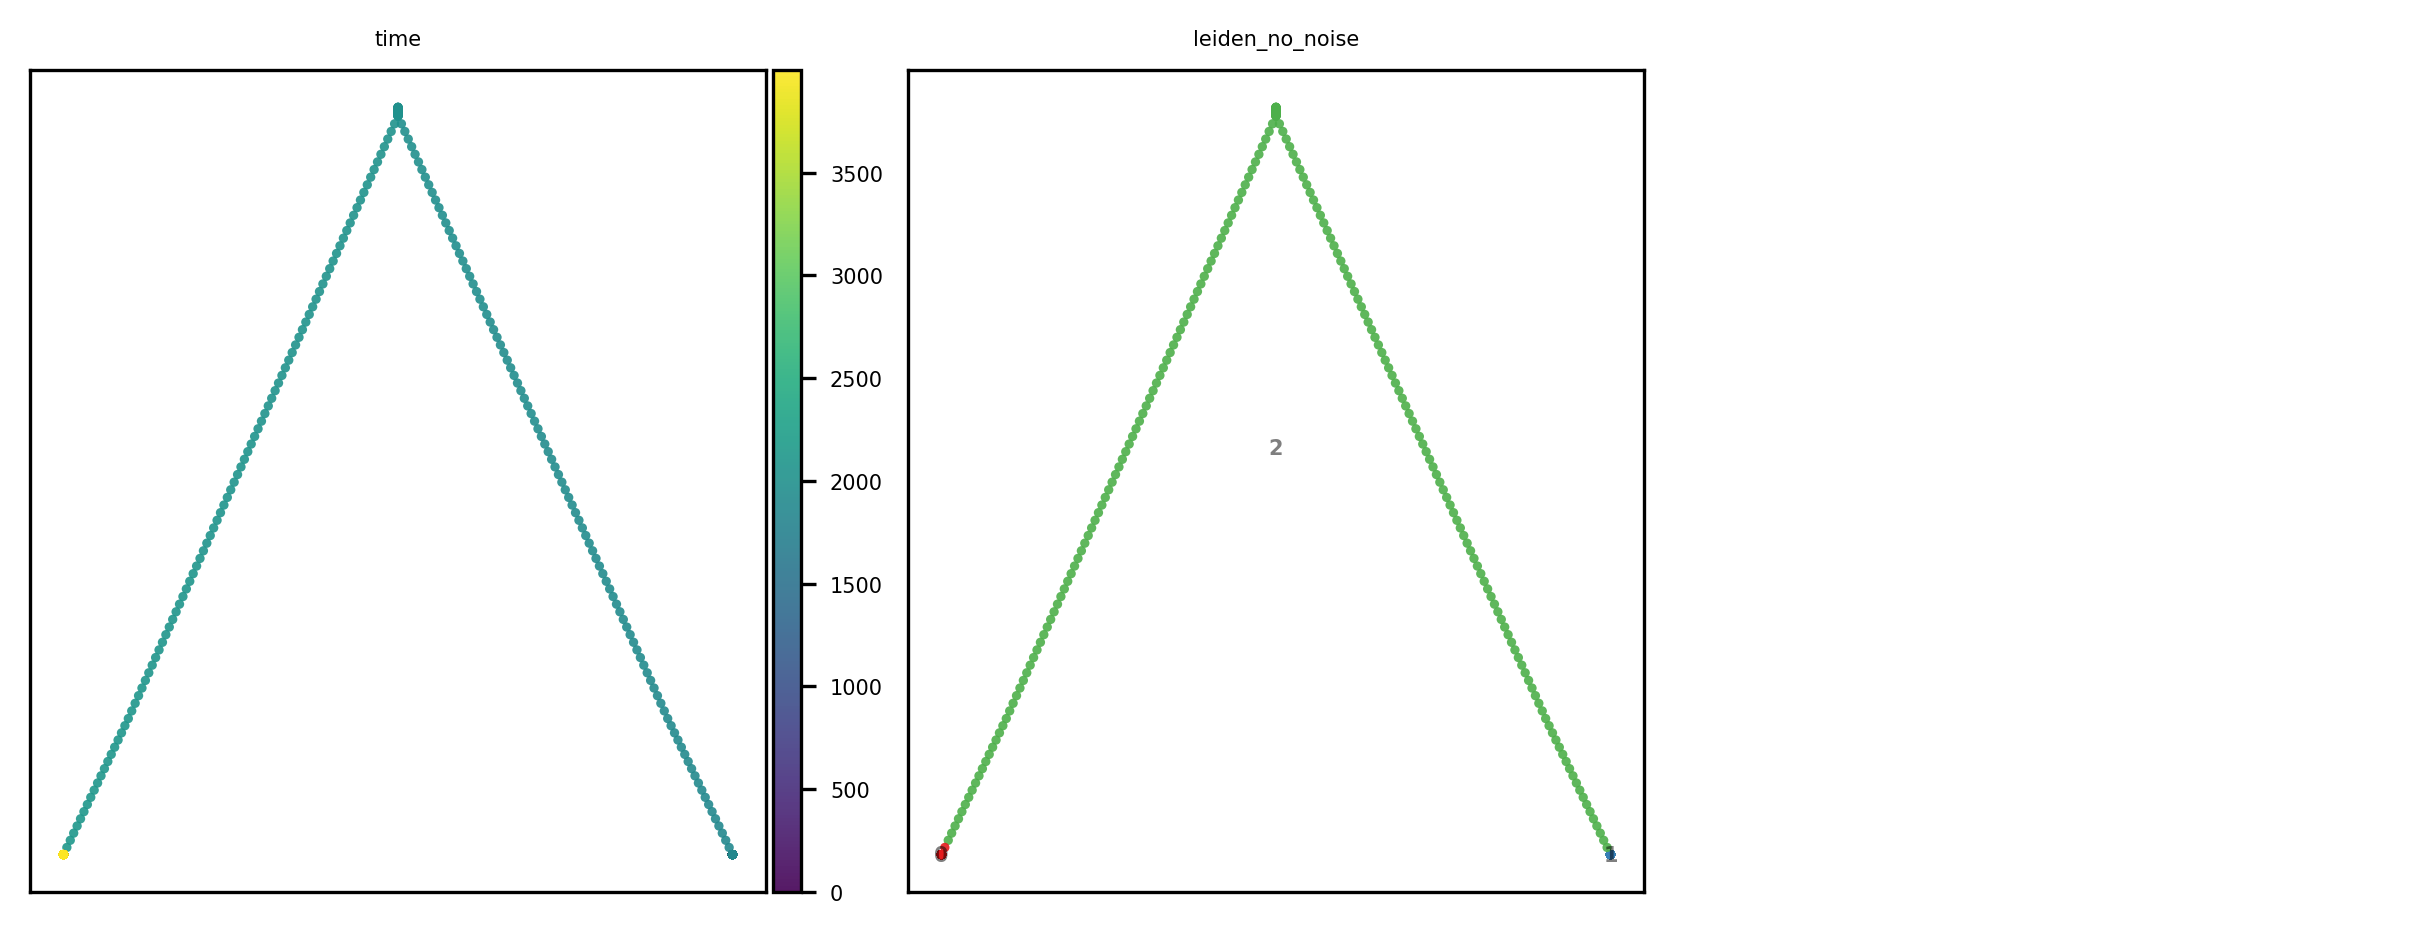

In [117]:
show_basis = 'PCA_no_noise'
show_cols = [state_key, leiden_key]

ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.svg"
)

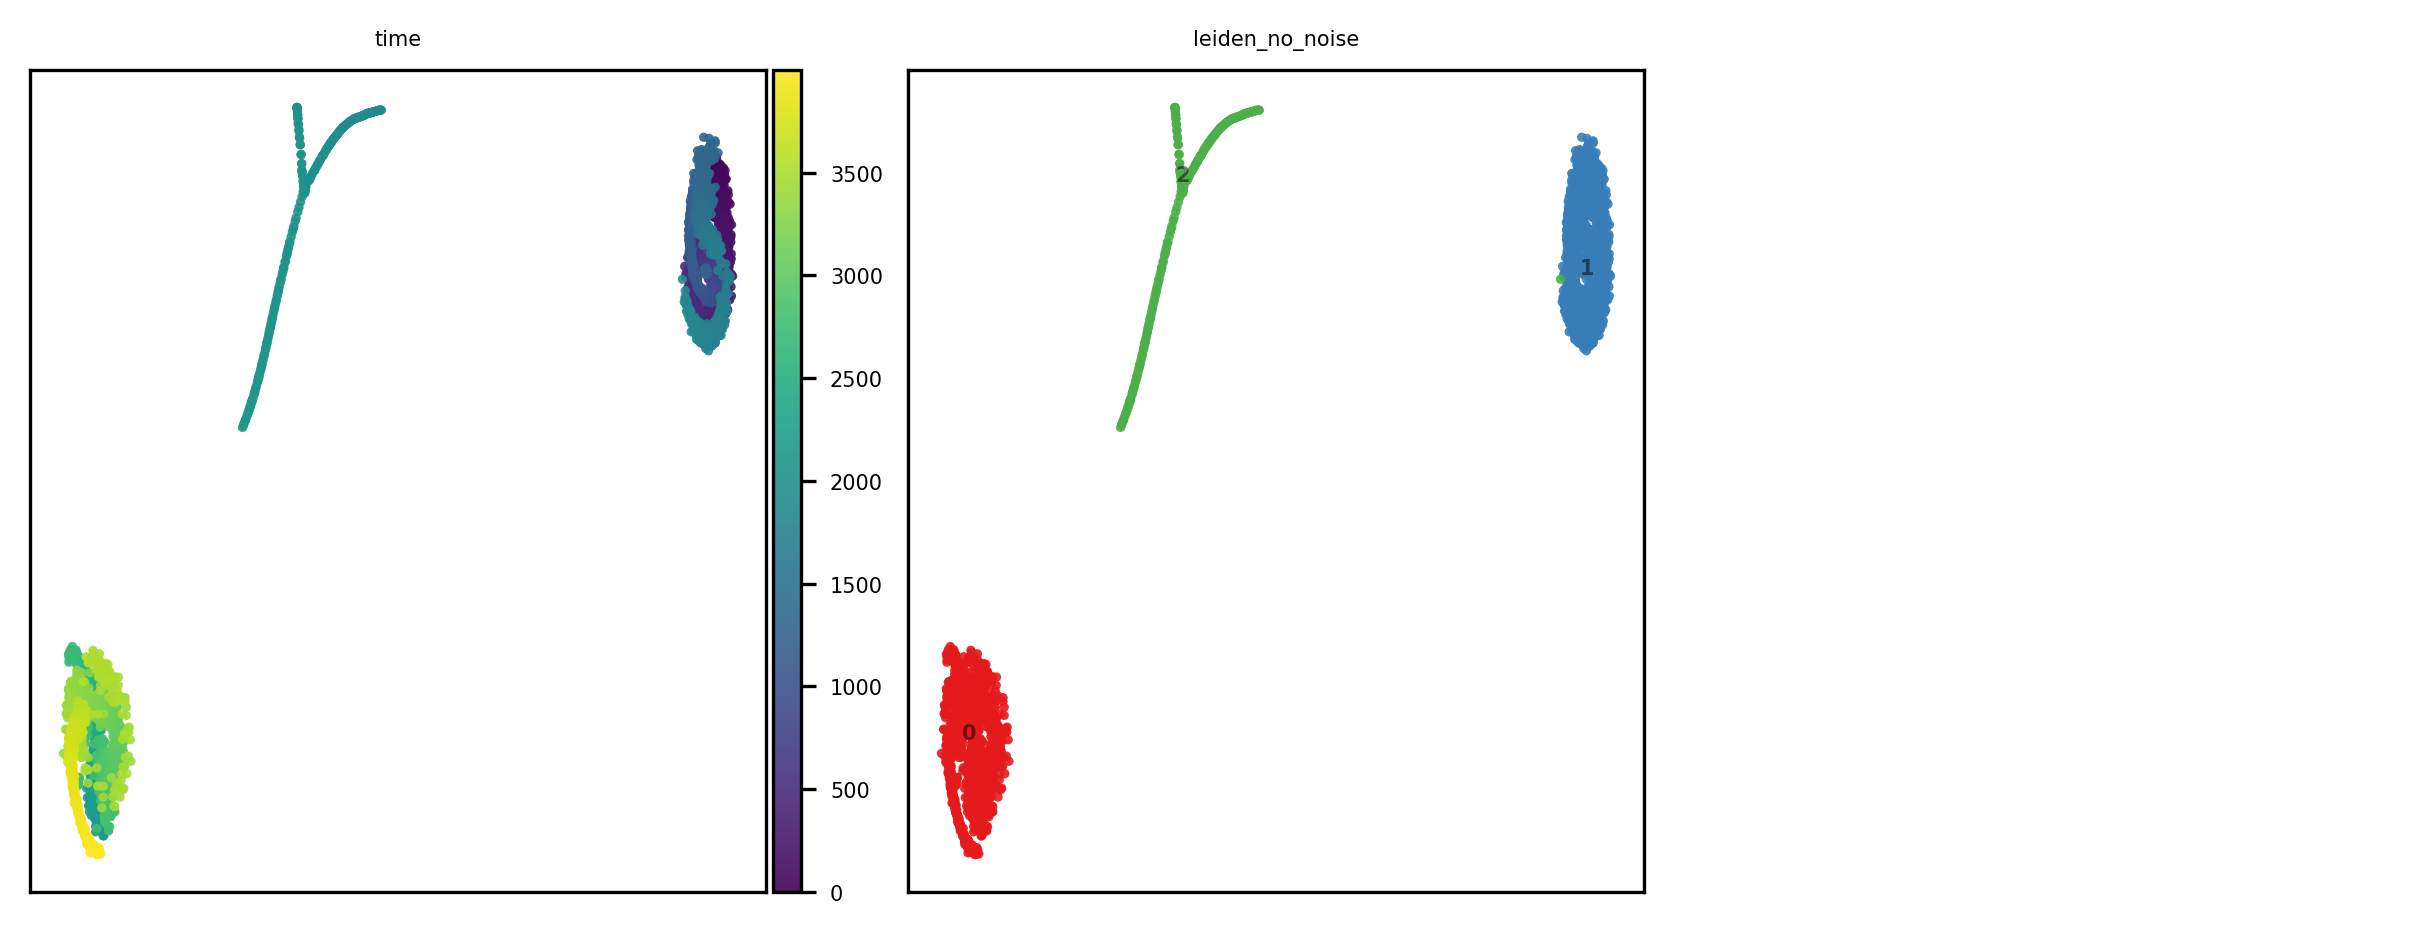

In [118]:
show_basis = 'UMAP_no_noise'

ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.svg"
)

In [119]:
concord_args_base = {
    'input_feature': None,
    'latent_dim': 10,
    'encoder_dims':[64],
    'decoder_dims':[64],
    'batch_size':16,
    'n_epochs': 10,
    'p_intra_knn': 0.2,
    'lr': 1e-2,
    'schedule_ratio': 0.97,
    'augmentation_mask_prob': 0.2,
    'clr_temperature':0.2,
    'sampler_knn':300,
    'dist_metric':'euclidean',
    'domain_key': None,
    'seed': seed,
    'device': device,
    'save_dir': save_dir
}

In [122]:
import copy
param_variations = {
    'p_intra_knn': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  # Example: vary p_intra_knn
    #'sampler_knn': [5, 10, 20, 30, 40, 50, 100]  # Example: vary sampler_knn
}
param_keys = []

# -------------------------------------
# 3. Loop over each parameter to vary
# -------------------------------------
for param_name, values in param_variations.items():
    print(f"\n[INFO] Varying '{param_name}' with possible values: {values}\n")
    
    for value in values:
        # 3a. Copy the base arguments
        concord_args = copy.deepcopy(concord_args_base)
        
        # 3b. Update the specific parameter we want to vary
        concord_args[param_name] = value
        
        # 3c. Indicate which param is varied and to which value
        output_key = f"Concord_{param_name}_{value}"
        # Append output_key to param_keys
        param_keys.append(output_key)
        umap_key   = output_key + '_UMAP'

        print(f"[INFO] Running Concord with {param_name} = {value}")
        
        # -------------------------------------
        # 4. Run Concord
        # -------------------------------------
        cur_ccd = ccd.Concord(adata, **concord_args)

        # Encode data, saving the latent embedding in adata.obsm[output_key]
        cur_ccd.encode_adata(
            input_layer_key='X',
            output_key=output_key,
            preprocess=False
        )
        
        # -------------------------------------
        # 5. (Optional) run UMAP on the new embedding
        # -------------------------------------
        ccd.ul.run_umap(
            adata,
            source_key=output_key,
            result_key=umap_key,
            n_components=2,
            n_neighbors=30,
            min_dist=0.5,
            metric='cosine',
            random_state=seed
        )
        

print("[DONE] Finished varying each parameter individually.")



[INFO] Varying 'p_intra_knn' with possible values: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

[INFO] Running Concord with p_intra_knn = 0.0
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.


Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 0.0


Epoch 0 Training: 250it [00:00, 596.65it/s, loss=9.99]
Epoch 9 Training: 100%|██████████| 250/250 [00:00<00:00, 637.97it/s, loss=8]   


[INFO] Running Concord with p_intra_knn = 0.1
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.
Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 0.1


Epoch 0 Training: 250it [00:00, 505.03it/s, loss=9.7] 
Epoch 9 Training: 100%|██████████| 250/250 [00:00<00:00, 514.24it/s, loss=7.65]


[INFO] Running Concord with p_intra_knn = 0.2
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.
Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 0.2


Epoch 0 Training: 250it [00:00, 499.51it/s, loss=8.66]
Epoch 9 Training: 100%|██████████| 250/250 [00:00<00:00, 511.83it/s, loss=7.69]


[INFO] Running Concord with p_intra_knn = 0.3
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.
Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 0.3


Epoch 0 Training: 250it [00:00, 510.69it/s, loss=9.55]
Epoch 9 Training: 100%|██████████| 250/250 [00:00<00:00, 503.56it/s, loss=8.76]


[INFO] Running Concord with p_intra_knn = 0.4
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.
Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 0.4


Epoch 0 Training: 250it [00:00, 466.83it/s, loss=10.1]
Epoch 9 Training: 100%|██████████| 250/250 [00:00<00:00, 513.48it/s, loss=8.39]


[INFO] Running Concord with p_intra_knn = 0.5
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.
Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 0.5


Epoch 0 Training: 250it [00:00, 532.78it/s, loss=8.84]
Epoch 9 Training: 100%|██████████| 250/250 [00:00<00:00, 534.50it/s, loss=7.87]


[INFO] Running Concord with p_intra_knn = 0.6
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.
Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 0.6


Epoch 0 Training: 250it [00:00, 475.45it/s, loss=8.91]
Epoch 9 Training: 100%|██████████| 250/250 [00:00<00:00, 509.83it/s, loss=8.48]


[INFO] Running Concord with p_intra_knn = 0.7
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.
Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 0.7


Epoch 0 Training: 250it [00:00, 506.18it/s, loss=10.1]
Epoch 9 Training: 100%|██████████| 250/250 [00:00<00:00, 513.13it/s, loss=8.33]


[INFO] Running Concord with p_intra_knn = 0.8
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.
Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 0.8


Epoch 0 Training: 250it [00:00, 497.71it/s, loss=10.6]
Epoch 9 Training: 100%|██████████| 250/250 [00:00<00:00, 508.01it/s, loss=8.68]


[INFO] Running Concord with p_intra_knn = 0.9
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.
Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 0.9


Epoch 0 Training: 250it [00:00, 507.04it/s, loss=10]  
Epoch 9 Training: 100%|██████████| 250/250 [00:00<00:00, 504.74it/s, loss=8.85]


[INFO] Running Concord with p_intra_knn = 1.0
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.
Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 1.0


Epoch 0 Training: 250it [00:00, 477.38it/s, loss=9.93]
Epoch 9 Training: 100%|██████████| 250/250 [00:00<00:00, 500.21it/s, loss=8.66]


[DONE] Finished varying each parameter individually.


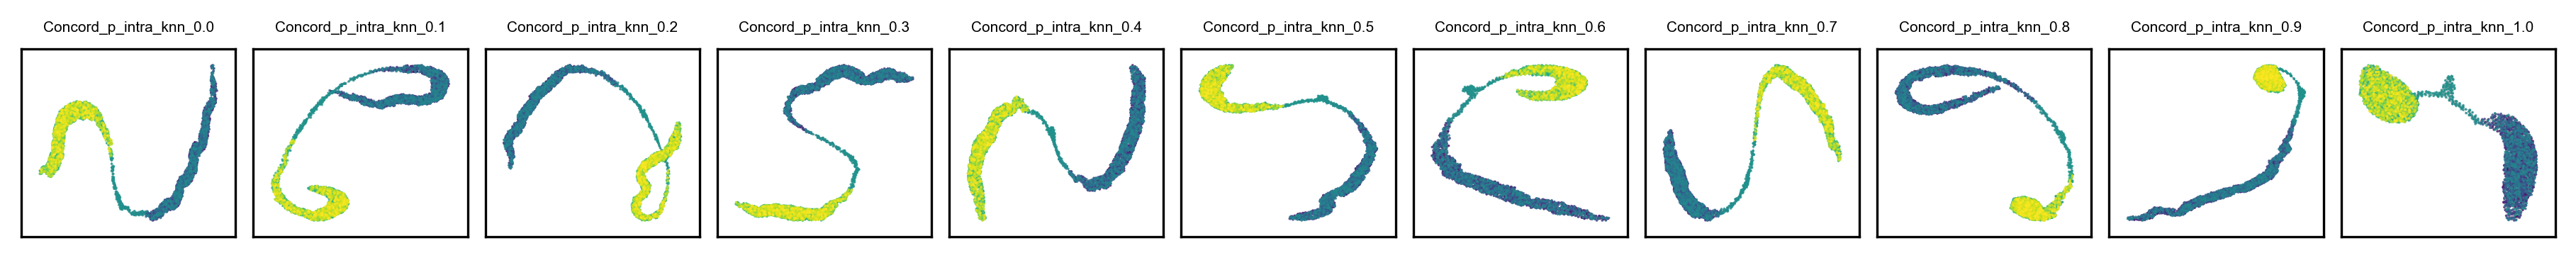

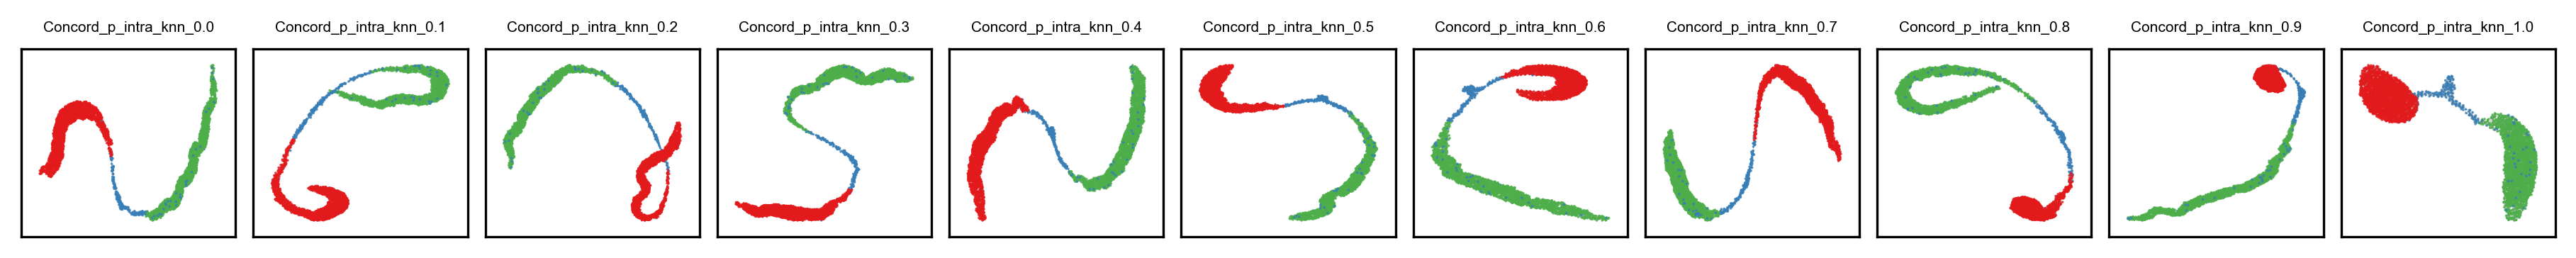

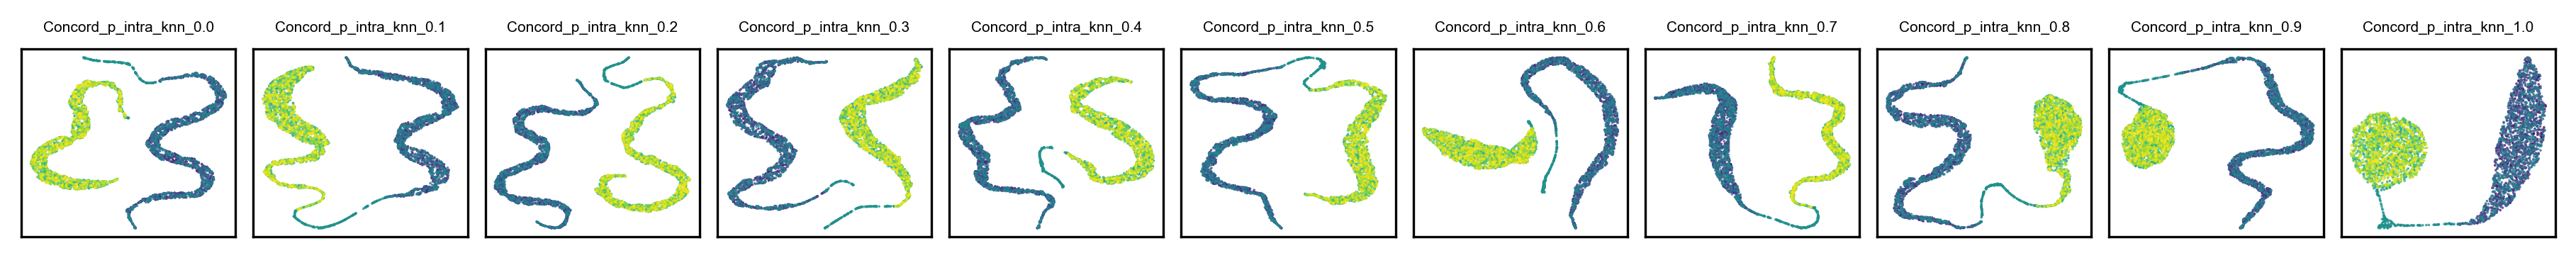

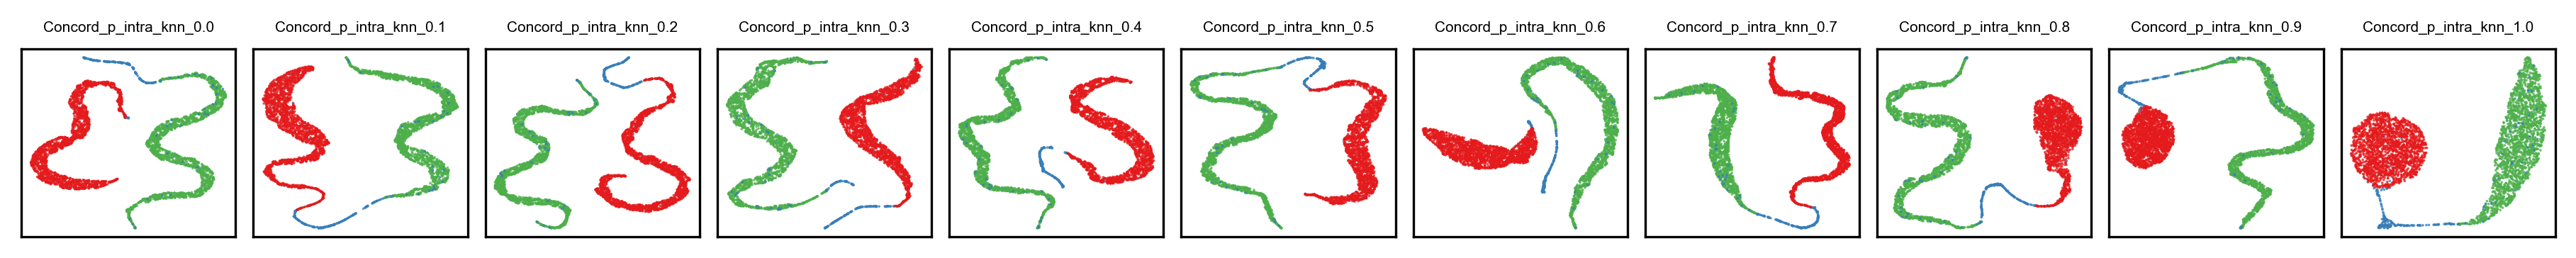

In [124]:
# plot everything
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import font_manager, rcParams
file_suffix = f"{time.strftime('%b%d-%H%M')}"
# Set Arial as the default font
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

color_bys = [state_key, leiden_key]
#basis_types = ['', 'PAGA', 'KNN', 'PCA', 'UMAP']
basis_types = ['KNN', 'UMAP']
font_size=5
point_size=3
alpha=0.8
figsize=(12,1.1)
ncols = len(param_keys)
nrows = int(np.ceil(len(param_keys) / ncols))
pal = {state_key:'viridis', batch_key:'Set1'}
k=10
edges_color='grey'
edges_width=0.05
layout='kk'
threshold = 0.1
node_size_scale=0.1
edge_width_scale=0.1

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        param_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        seed=1,
        leiden_key='leiden',
        save_dir=save_dir,
        file_suffix=file_suffix,
        save_format='pdf'
    )
